# Анализ данных осень 2021
# Практический анализ данных и ML соревнования

### Зачем участвтовать

- Полезно для резюме
- Полезно для скорости работы
- Иногда прибыльно
- Полезно для навыков, если вы не kaggle expert

### Чему научили за курс

- Быть линтером питона
- Перекладывать одни колонки данных в другие
    
    выделять признаки в данных, но не ясно какие из них полезны. И для чего полезны
    
- Применять непонятные ML модели к сырым данным

    алгоритмы AutoML делают похожую работу, но подбирают нужные параметры быстрее программистов
    
- Выделять на графиках закономерности, которые понятны без графиков

    сложно найти что-то в данных без цели. Проще предполагать по данным что может быть правдой, а что нет

Вопросы без ответа

- Что считать хорошим анализом данных
- Что делать с плохим количеством данных
- Как смотреть на данные

## Пример с соревнования

Возьмём задачу из VK Cup 2020 года. Нужно:

- разобраться в данных, похожих на логи рекламных компаний соцсети
- придумать алгоритм оценки охвата аудитории
- посмотреть насколько точно предсказывается размер аудитории

**Будет много графиков**

#### Данные

In [1]:
!tree /f data/raw

Folder PATH listing
Volume serial number is 38FF-D290
K:\ITMO\5 семестр\Практики\DA\VK\DATA\RAW
    ads.csv
    history.csv
    sample_solution.csv
    target.csv
    users.csv
    
No subfolders exist 



`users.csv` - данные об аудитории == пользователях соцсети:
- `user_id`, `sex`, `age`, `city_id`

`history.csv` - данные о рекламных компаниях:
- `hour` – в какой час пользователь видел объявление
- `cpm` - цена показанного рекламного объявления в рекламном аукционе. Это значит, что на данном аукционе это была максимальная ставка. 
- `publisher` - площадка, на который пользователь видел рекламу
- `user_id`

`target.csv` - данные об охвате аудитории рекламной компании:
- `at_least_one` - доля пользователей, которая увидит объявление **хотя бы 1 раз**

### Разберёмся в данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [14, 3]

#### О пользователях

In [3]:
users = pd.read_csv('data/raw/users.csv')
print(f'dataset shape: {users.shape}')
users.head(7)

dataset shape: (27769, 4)


,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4
5,5,2,22,5
6,6,1,21,6


<AxesSubplot:>

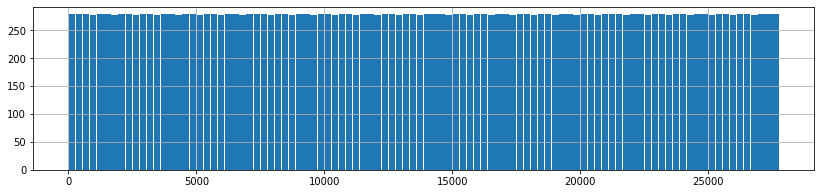

In [4]:
# Пользователи с какими id есть в данных?

users.user_id.hist(bins=100, rwidth=0.9)

<AxesSubplot:>

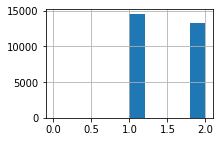

In [5]:
# Пол пользователей

users.sex.hist(figsize=(3, 2))

<AxesSubplot:>

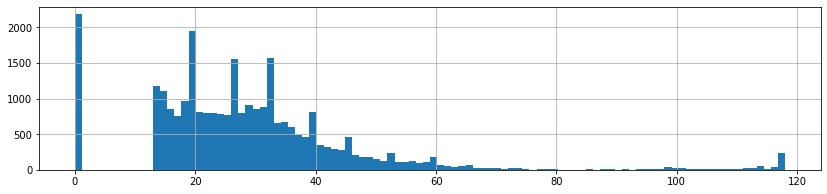

In [6]:
# Возраст

users.age.hist(bins=100)

<AxesSubplot:>

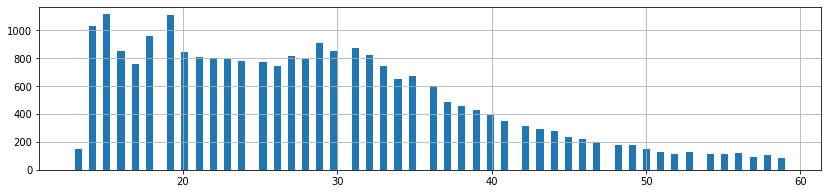

In [7]:
# Возраст основной аудитории

users[(users.age > 0) & (users.age < 60)].age.hist(bins=100)

Количество городов: 2457


<AxesSubplot:>

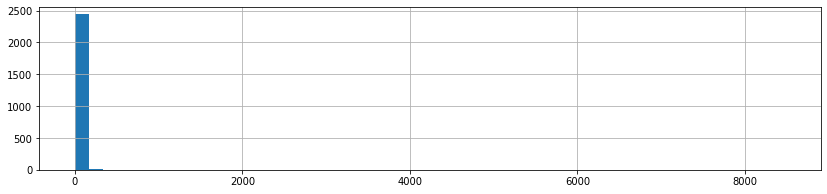

In [8]:
# Города пользователей

print(f'Количество городов: {len(users.city_id.unique())}')
# Сколько пользователей в каждом городе
vc = users.value_counts('city_id')
vc.hist(bins=50)

<AxesSubplot:>

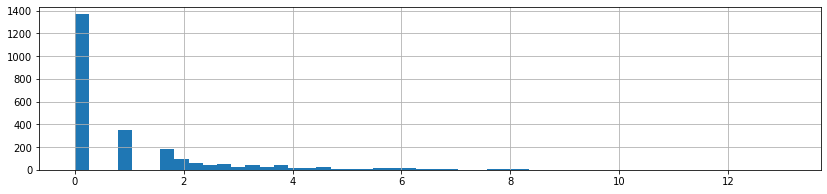

In [9]:
# Логарифмированное количество жителей городов
log2_vc = np.log2(vc)
log2_vc.hist(bins=50)

##### Менее тривиальные графики

<AxesSubplot:>

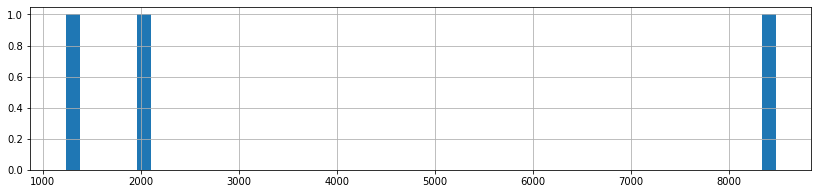

In [10]:
# Города с населением более 1к
vc[vc > 1000].hist(bins=50)

In [11]:
# Исследуем жителей больших городов
vc[vc > 1000]

city_id
0    8479
3    1985
7    1232
dtype: int64

In [12]:
cities_users = users[users.city_id.isin([0, 3, 7])]
cities_users.shape

(11696, 4)

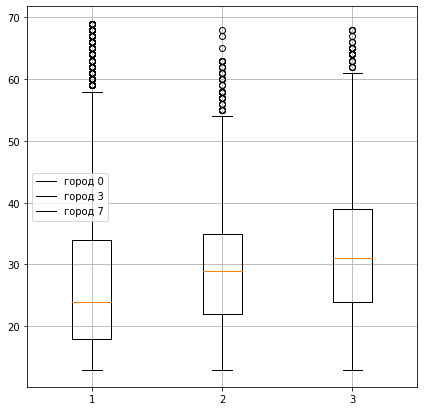

In [13]:
# Их возраст по городам

city_ages = cities_users[(cities_users.age > 0) & (cities_users.age < 70)].groupby('city_id').age.apply(list)

plt.figure(figsize=(7, 7))
plt.boxplot(city_ages)
plt.grid(True)
plt.legend([f'город {city_id}' for city_id in city_ages.index])
plt.show()

#### О рекламных компаниях

In [14]:
history = pd.read_csv('data/raw/history.csv')
print(history.shape)
history.head(7)

(1147857, 4)


,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148
5,5,70.00,2,16334
6,10,73.22,1,25931


<AxesSubplot:>

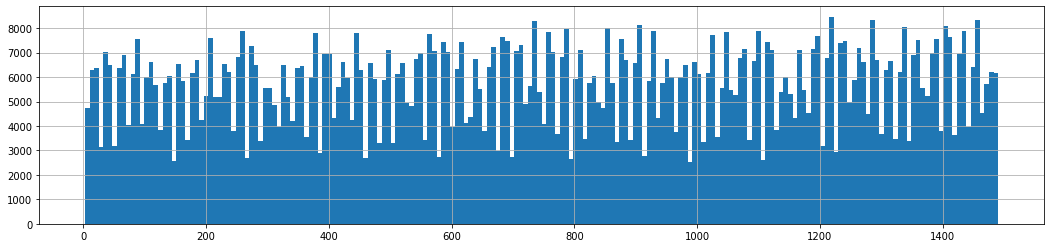

In [15]:
# Время объявлений в ходе всего периода сбора данных
history.hour.hist(bins=200, figsize=(18, 4))

<AxesSubplot:>

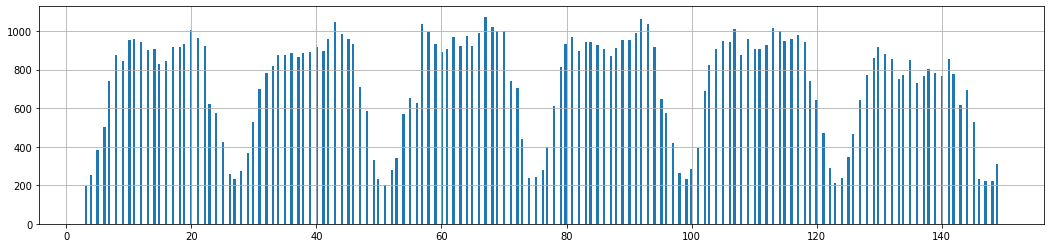

In [16]:
# Подробнее
history[history.hour < 150].hour.hist(bins=400, figsize=(18, 4))

<AxesSubplot:>

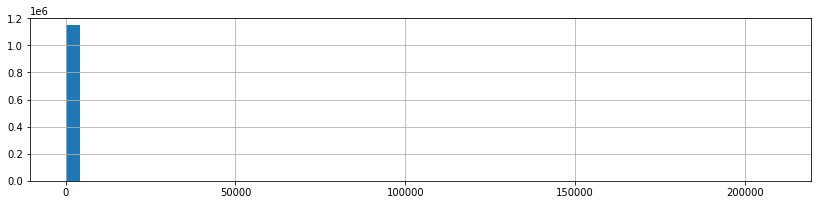

In [17]:
# Цены объявлений
history.cpm.hist(bins=50)

<AxesSubplot:>

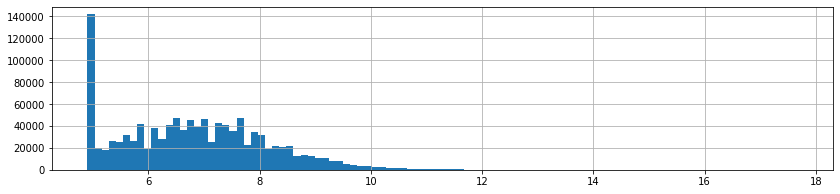

In [18]:
# Логарифмированные
cpms = history.cpm.apply(np.log2)
cpms.hist(bins=100)

<AxesSubplot:>

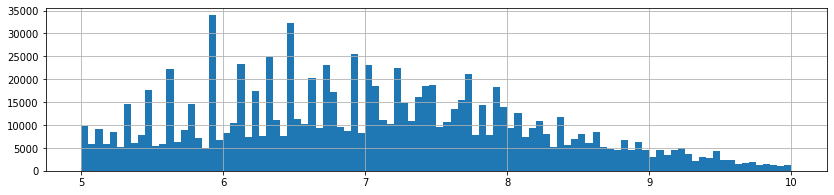

In [19]:
# Подробнее 
cpms[(cpms > 5) & (cpms < 10)].hist(bins=100)

21


Text(0, 0.5, 'Количество таких платформ')

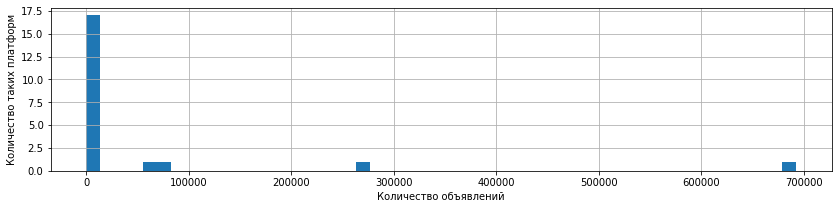

In [20]:
# Что за платформы для рекламы? Сколько их?

print(len(history.publisher.unique()))
vc = history.publisher.value_counts()
vc.hist(bins=50)
plt.xlabel('Количество объявлений')
plt.ylabel('Количество таких платформ')

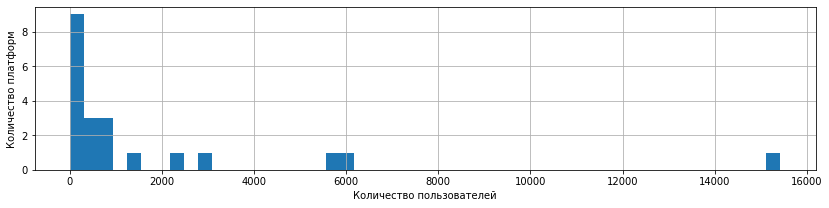

In [21]:
# Сколько уникальных пользователей на платформах?
users_per_publisher = history.groupby('publisher').user_id.apply(lambda users: len(set(users)))
users_per_publisher.hist(bins=50)
plt.xlabel('Количество пользователей')
plt.ylabel('Количество платформ');

In [22]:
# Какой трафик на каждой платформе?

# Посчитаем для каждого часа: сколько постов было на каждой платформе?

n_publishers = len(history.publisher.unique())
posts_per_hour_by_publishers = []
TAKE_FIRST_N_HOURS = 24 * 4

for hour, hour_data in history[history.hour < TAKE_FIRST_N_HOURS].groupby('hour'):
    publishers_posts = hour_data.value_counts('publisher')
    
    counts = [0 for _ in range(n_publishers)]
    for pub_id, posts_n in list(publishers_posts.items()):
        counts[pub_id-1] = posts_n
        
    posts_per_hour_by_publishers.append([hour] + counts)

    
df = pd.DataFrame.from_records(posts_per_hour_by_publishers, columns=['hour'] + list(history.publisher.unique()))
df

,hour,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,21,20
0,3,100,67,11,1,3,1,7,0,2,...,0,0,0,0,2,1,0,0,0,0
1,4,173,51,10,0,1,1,11,1,2,...,1,0,0,0,1,0,0,0,0,0
2,5,246,91,21,1,1,4,12,3,2,...,2,1,0,0,0,0,0,0,0,0
3,6,346,95,27,2,0,5,16,1,4,...,0,0,0,0,1,1,0,0,0,0
4,7,488,157,29,2,5,5,42,3,6,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,91,625,217,47,1,6,3,65,4,9,...,1,0,0,0,0,0,0,0,1,0
89,92,646,268,51,0,7,3,67,3,1,...,1,1,1,0,0,0,0,0,0,0
90,93,608,262,69,1,6,7,62,3,4,...,1,0,1,1,0,0,0,0,0,0
91,94,532,233,62,2,5,4,62,2,3,...,0,0,0,1,0,3,0,0,0,0


In [23]:
top_publishers = history.value_counts('publisher').sort_values(ascending=False).index.to_numpy()[0:4]
top_publishers

array([1, 2, 3, 7], dtype=int64)

Text(0, 0.5, 'Количество постов')

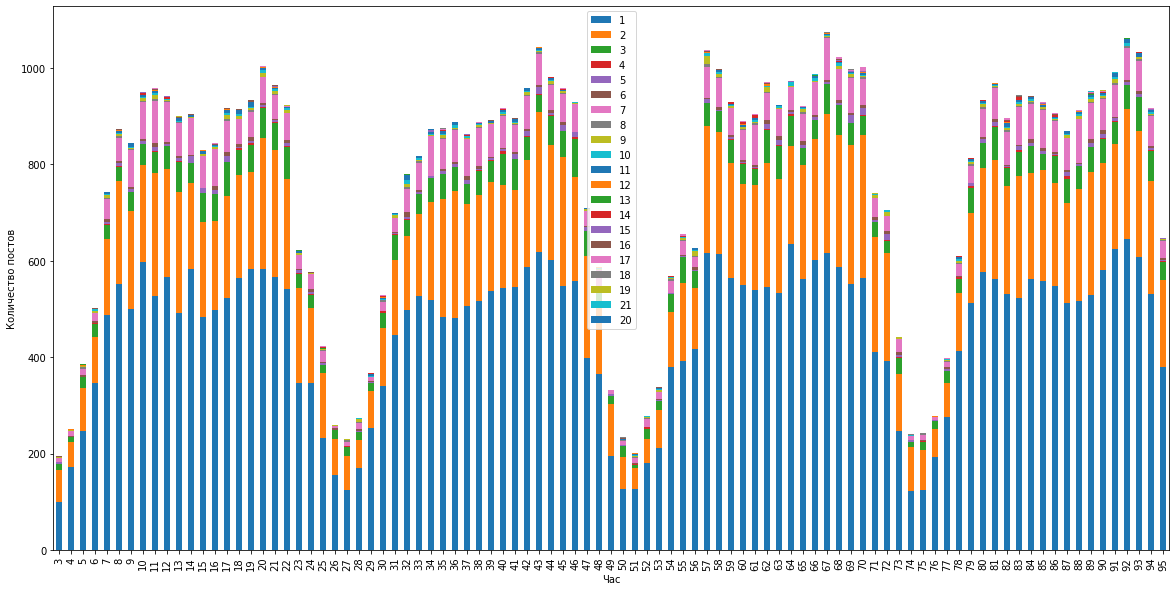

In [24]:
df.plot.bar(x='hour', stacked=True, figsize=(20, 10))
plt.xlabel('Час')
plt.ylabel('Количество постов')

<AxesSubplot:>

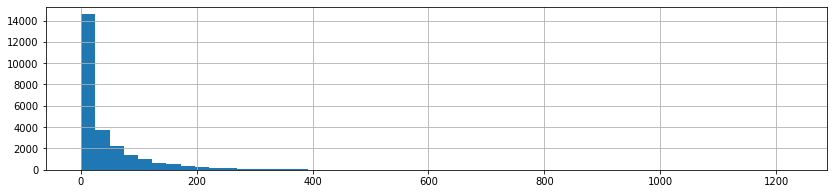

In [25]:
# И сколько постов посмотрел каждый пользователь?
vc = history.value_counts('user_id')
vc.hist(bins=50)

Text(0, 0.5, 'Количество таких пользователей')

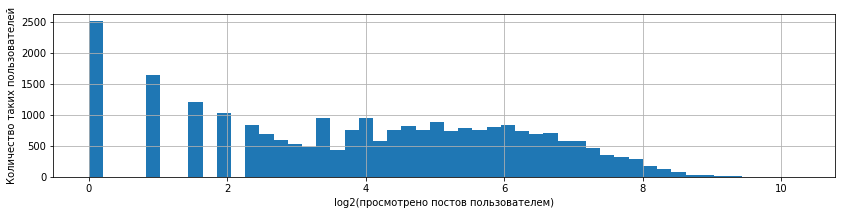

In [26]:
# Логарифмируем
np.log2(vc).hist(bins=50)
plt.xlabel('log2(просмотрено постов пользователем)')
plt.ylabel('Количество таких пользователей')

#### Об результате рекламных компаний

In [27]:
posts = pd.read_csv('data/raw/ads.csv')
posts.head(7)

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,ad_id
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1...",0
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3...",1
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5...",2
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524...",3
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2...",4
5,141.0,1288,1322,"3,8,11,15",856,"111,217,235,247,292,340,398,540,541,546,581,61...",5
6,250.0,1198,1451,"1,3,7,10,13,18",336,"24,43,96,124,150,256,299,313,430,450,552,557,5...",6


<AxesSubplot:>

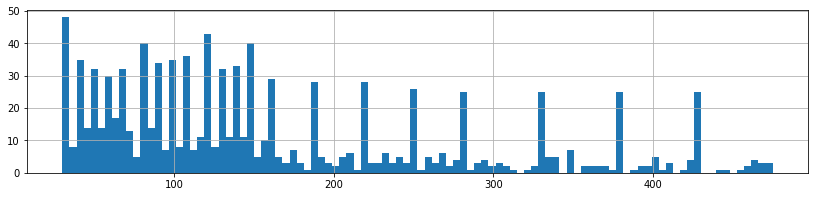

In [28]:
# Сколько по итогам аукциона стоит объявление
posts.cpm.hist(bins=100)

<AxesSubplot:>

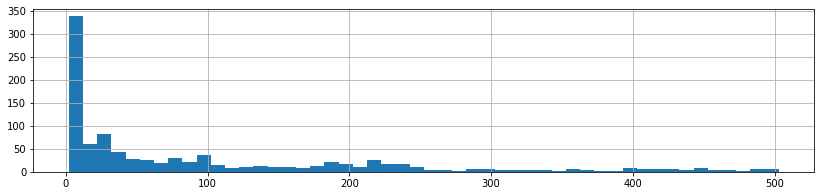

In [29]:
# Сколько часов длится рекламная компания

duration = (posts.hour_end - posts.hour_start)
duration.hist(bins=50)

Text(0, 0.5, 'количество объявлений')

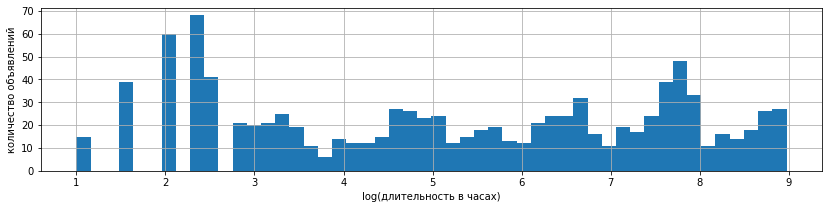

In [30]:
np.log2(duration).hist(bins=50)
plt.xlabel('log(длительность в часах)')
plt.ylabel('количество объявлений')

<AxesSubplot:>

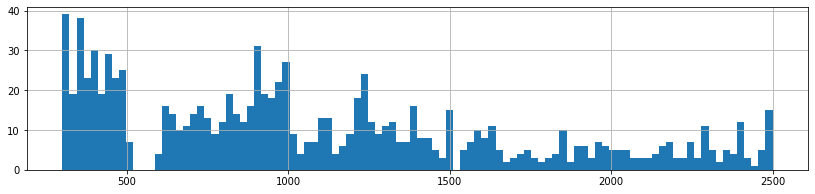

In [31]:
# На какую аудиторию крутилось объявление

posts.audience_size.hist(bins=100)

#### Об охвате

In [32]:
answers = pd.read_csv('data/raw/target.csv')
answers.head(7)

,ad_id,at_least_one
0,0,0.0430
1,1,0.0130
2,2,0.0878
3,3,0.2295
4,4,0.3963
5,5,0.0187
6,6,0.3839


<AxesSubplot:>

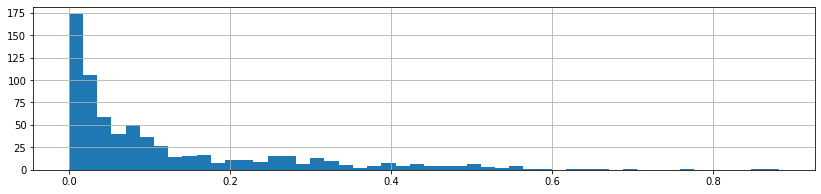

In [33]:
# Какая часть аудитории увидело объявление хоть раз
answers.at_least_one.hist(bins=50)

Если у вас нет непонимания и вопросов о данных, то вы посмотрели хороший анализ данных. Возможно выше неплохой анализ

### Построим модель

#### Выделим числовые признаки

In [34]:
import seaborn as sns

In [35]:
# Соберём простую информацию по каждому объявлению в датасет

# Добавим номер объявления
posts = posts.assign(id=posts.index)
answers = answers.assign(id=answers.index)


ads_raw = posts
ads_raw.head(3)

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,ad_id,id
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1...",0,0
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3...",1,1
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5...",2,2


In [36]:
# Добавим пару простых признаков

def count_day_hours(hour_starts, hour_ends):
    # [8..22]
    n_dayss = (hour_ends - hour_starts) // 24
    cycle_day_hours = (22 - 8 + 1) * n_dayss
    rem_day_hours = [sum(1 for x in range(hour_start + 24 * n_days, hour_end) if 8 <= x % 24 <= 22)
                     for n_days,hour_start,hour_end in zip(n_dayss, hour_starts, hour_ends)]
    return cycle_day_hours + np.array(rem_day_hours)

ads_raw['user_refs']=ads_raw.user_ids.apply(lambda s: users[users.user_id.isin(np.array(s.split(','), dtype=int))])

ads_all = ads_raw.assign(
    mean_age=ads_raw.user_refs.apply(lambda x: x.age.apply(lambda x: np.nan if x < 13 or x > 80 else x).mean()),
    log_cpm=np.log(ads_raw.cpm),
    log_n_publishers=np.log(ads_raw.publishers.apply(lambda s: len(s.split(',')))),
    log_duration=np.log(ads_raw.hour_end - ads_raw.hour_start),
    log_audience_size=np.log(ads_raw.audience_size),
    log_day_hours=np.log(np.maximum(count_day_hours(ads_raw.hour_start, ads_raw.hour_end), 1)),
    n_top_publishers=ads_raw.publishers.apply(lambda ps: len(np.intersect1d(np.array(ps.split(','), dtype=int), top_publishers)))
)

ads_all.mean_age.fillna(users.age.mean(), inplace=True)

ads = pd.merge(ads_all, answers, on='id')

useful_columns = [
 'log_cpm',
 'log_duration',
 'log_n_publishers',
 'log_audience_size',
 'log_day_hours',
 'n_top_publishers',
 'mean_age'
]

ads = ads[useful_columns + ['at_least_one']]
ads.head(5)
ads.describe()

,log_cpm,log_duration,log_n_publishers,log_audience_size,log_day_hours,n_top_publishers,mean_age,at_least_one
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,4.854380,3.609522,1.133232,6.823102,3.093694,2.002857,29.766732,0.118539
std,0.719709,1.616218,0.501356,0.598135,1.709667,0.814738,8.691380,0.146539
min,3.401197,0.693147,0.000000,5.703782,0.000000,1.000000,14.385417,0.000100
25%,4.366263,2.079442,0.693147,6.406864,1.609438,1.000000,27.707860,0.018175
50%,4.867534,3.675579,1.098612,6.866933,3.178054,2.000000,29.263527,0.058450
75%,5.418313,5.198497,1.609438,7.282755,4.711772,3.000000,30.221067,0.163825
max,6.163315,6.220590,1.791759,7.824046,5.749393,3.000000,66.088542,0.881900


C:\Users\nh5\AppData\Local\Temp/ipykernel_24040/3272404392.py:2: RuntimeWarning: Mean of empty slice.
  sns.histplot(ages_by_ads.apply(lambda x: x.mean()))


<AxesSubplot:xlabel='user_refs', ylabel='Count'>

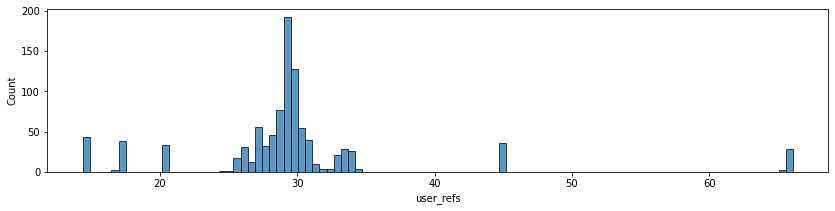

In [63]:
ages_by_ads = ads_raw.user_refs.apply(lambda us: us.age.apply(lambda x: np.nan if x < 13 or x > 80 else x).dropna().to_numpy())
sns.histplot(ages_by_ads.apply(lambda x: x.mean()))

In [74]:
ages_by_ads[(ages_by_ads.apply(lambda x: x.mean()) > 10) & (ages_by_ads.apply(lambda x: x.mean()) < 15)]

C:\Users\nh5\AppData\Local\Temp/ipykernel_24040/3806902563.py:1: RuntimeWarning: Mean of empty slice.
  ages_by_ads[(ages_by_ads.apply(lambda x: x.mean()) > 10) & (ages_by_ads.apply(lambda x: x.mean()) < 15)]


18     [15, 15, 14, 15, 15, 15, 14, 15, 15, 15, 14, 1...
21     [15, 14, 14, 14, 14, 14, 15, 15, 14, 15, 15, 1...
22     [15, 14, 14, 14, 15, 15, 14, 15, 14, 15, 15, 1...
23     [15, 14, 14, 14, 14, 15, 15, 15, 15, 14, 15, 1...
48     [15, 15, 14, 15, 15, 15, 14, 15, 15, 15, 15, 1...
76     [15, 14, 14, 14, 14, 15, 15, 15, 14, 15, 15, 1...
79     [15, 14, 15, 15, 14, 15, 13, 14, 15, 15, 15, 1...
152    [15, 15, 14, 14, 15, 14, 15, 14, 15, 15, 15, 1...
196    [14, 14, 15, 14, 15, 14, 15, 13, 14, 14, 15, 1...
205    [15, 15, 14, 14, 14, 14, 14, 15, 15, 15, 14, 1...
224    [15, 14, 14, 15, 14, 15, 15, 14, 15, 14, 13, 1...
230    [15, 14, 14, 14, 15, 15, 15, 15, 14, 14, 14, 1...
238    [15, 15, 14, 14, 14, 14, 14, 15, 14, 15, 15, 1...
242    [15, 15, 14, 14, 14, 14, 15, 15, 15, 14, 15, 1...
277    [15, 15, 14, 14, 14, 14, 15, 15, 15, 14, 15, 1...
303    [14, 14, 14, 14, 15, 15, 14, 15, 15, 15, 14, 1...
317    [15, 14, 14, 14, 15, 15, 15, 14, 14, 15, 14, 1...
321    [15, 14, 14, 14, 15, 15,

<AxesSubplot:xlabel='user_refs', ylabel='Count'>

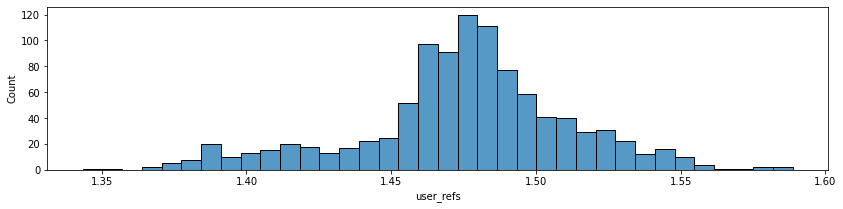

In [76]:
genders_by_ads = ads_raw.user_refs.apply(lambda us: us.sex.apply(lambda x: np.nan if x == 0 else x).dropna().to_numpy())
sns.histplot(genders_by_ads.apply(lambda x: x.mean()))

C:\Users\nh5\AppData\Local\Temp/ipykernel_24040/1576706174.py:1: RuntimeWarning: Mean of empty slice.
  sns.scatterplot(ages_by_ads.apply(lambda x: x.mean()), genders_by_ads.apply(lambda x: x.mean()))
C:\Users\nh5\miniconda3\envs\VK\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='user_refs', ylabel='user_refs'>

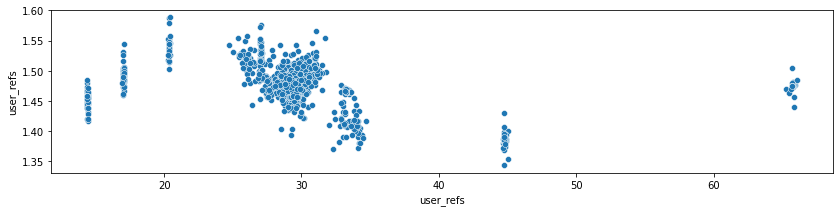

In [65]:
sns.scatterplot(ages_by_ads.apply(lambda x: x.mean()), genders_by_ads.apply(lambda x: x.mean()))

In [37]:
def heatmap(data: pd.DataFrame):
    plt.figure(figsize=(10, 9))
    sns.heatmap(data.corr(), square=True, linecolor='white', annot=True)
    plt.yticks(rotation=30)
    plt.xticks(rotation=30)
    plt.show()

<Figure size 720x648 with 0 Axes>

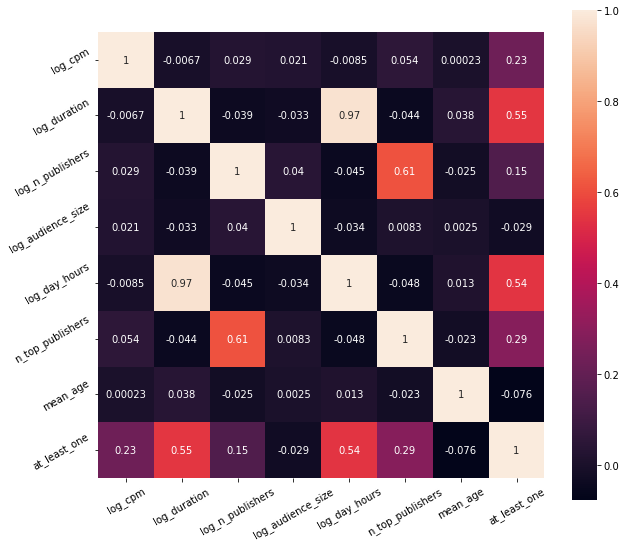

In [38]:
plt.figure(figsize=(10, 9))
heatmap(ads)

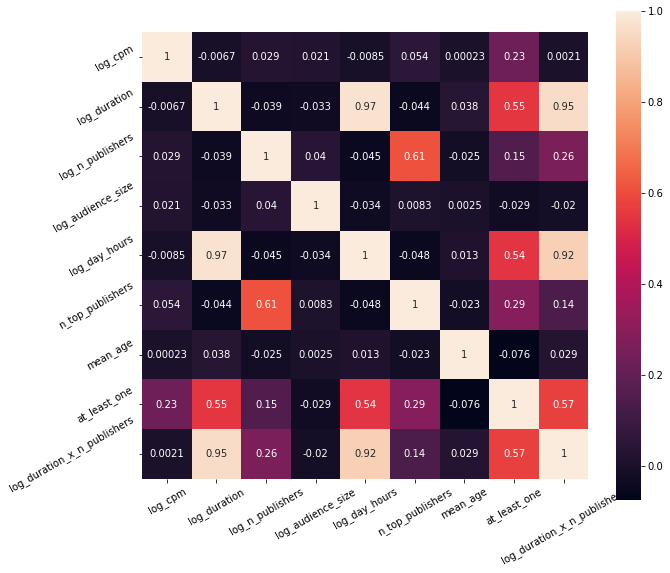

In [39]:
# Добавим дата саенс
ads_featured = ads.assign(log_duration_x_n_publishers=ads.log_duration + ads.log_n_publishers)
heatmap(ads_featured)

#### Обучим линейную регрессию

In [40]:
from typing import Tuple
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [41]:
def make_xy(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series, pd.Series]:
    x = data.drop('at_least_one', axis=1)
    y = data['at_least_one']
    logy = np.log(data['at_least_one'])
    return x, y, logy

In [42]:
def mape(pred: np.ndarray, trueth: np.ndarray) -> np.ndarray:
    # mean_absolute_percentage_error with clipping huge values
    err = np.array(abs(pred - trueth) / trueth)
    err[err > 20] = 20 # clip 2000% error
    return err

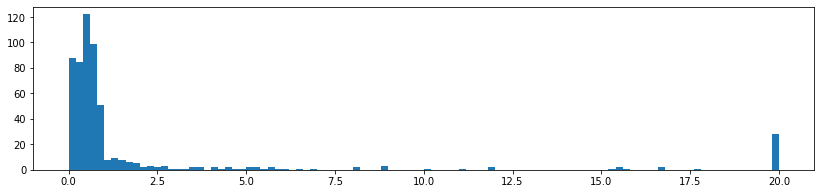

Ошибка на train: 2.0833386164769667
Ошибка на test: 1.5618119401145651


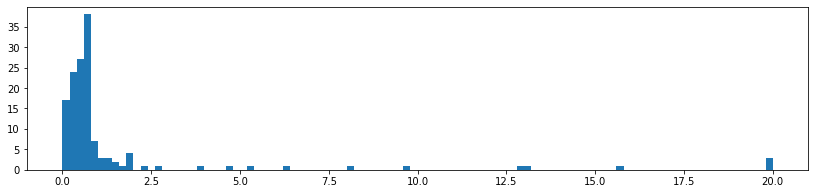

In [43]:
train, test = train_test_split(ads,
                               test_size=0.2,
                               random_state=0)
# train, test = train_test_split(ads.assign(
#                           dur_x_audience=np.exp(ads.logduration)*ads.audience_size,
#                           log_dur_x_audience=ads.logduration + np.log(ads.audience_size),
#                           log_cpm_x_duration=ads.logduration + np.log(ads.cpm)
#                                          ),
#                                test_size=0.2,
#                                random_state=42)

# Обучим модель
x, y, logy = make_xy(train)
model = LinearRegression().fit(x, logy)

# Оценим ошибку
errors = mape(np.exp(model.predict(x)), y)
plt.hist(errors, bins=100)
plt.show()
print('Ошибка на train:', errors.mean())

# Оценим ошибку на тесте
x, y, logy = make_xy(test)
errors = mape(np.exp(model.predict(x)), y)
plt.hist(errors, bins=100)
print('Ошибка на test:', errors.mean())

In [44]:
# Predict solution
ads_predict = ads_all.drop(range(0, 700))
solution = np.exp(model.predict(ads_predict[useful_columns]))
solution_df = pd.DataFrame(solution, ads_predict.index, columns=['at_least_one'])
solution_df.index.name = 'ad_id'
solution_df

solution_df.to_csv('solution.csv')

### Насколько вообще разделимы данные?

In [45]:
import umap

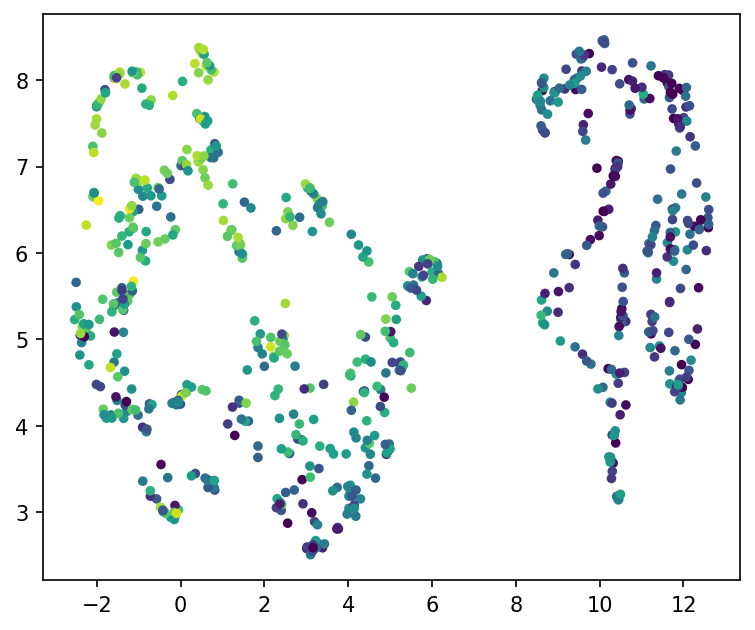

In [46]:
# Покажем похожие объявления точками, а охват цветом
embedding = umap.UMAP().fit_transform(ads[['log_cpm', 'log_duration', 'log_n_publishers']])

plt.figure(figsize=(6, 5), dpi=150)

color = np.log1p(ads.at_least_one * 100)
plt.scatter(embedding[:, 0], embedding[:, 1], s=13, c=color)

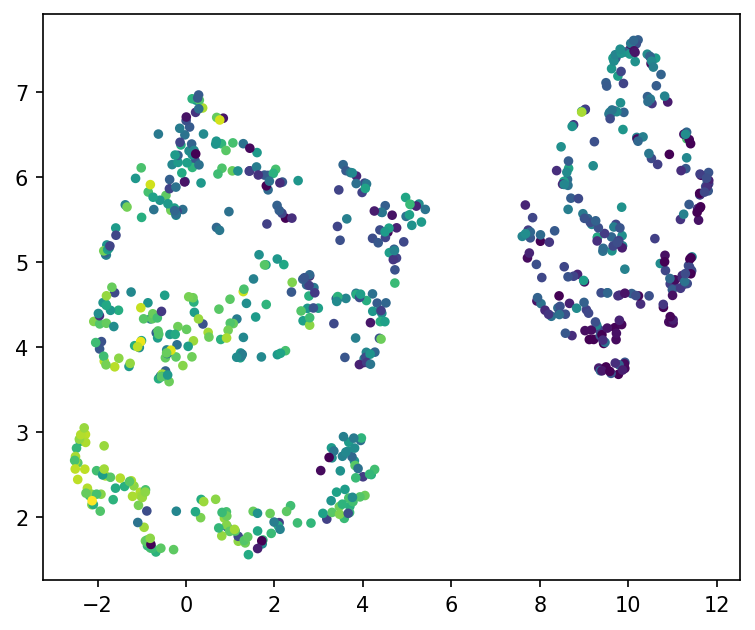

In [47]:
# Покажем похожие объявления точками, а охват цветом. Но на данных с доп фичами
embedding = umap.UMAP().fit_transform(ads_featured[['log_cpm', 'log_duration', 'log_duration', 'log_n_publishers', 'log_duration_x_n_publishers', 'log_audience_size', 'log_day_hours', 'n_top_publishers']])

plt.figure(figsize=(6, 5), dpi=150)

color = np.log1p(ads.at_least_one * 100)
plt.scatter(embedding[:, 0], embedding[:, 1], s=13, c=color)

## Конец первой части курса